In [65]:
import pandas as pd
import pyreadstat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [71]:
def performance(TP, TN, FP, FN, BETA):
    
    # 총 데이터 개수
    N = TP + TN + FP + FN
    
    # 성능 지표 계산
    Sensitivity = (TP / (TP + FN)) * 100
    Specificity = (TN / (TN + FP)) * 100
    Accuracy = ((TP + TN) / N) * 100
    PPV = (TP / (TP + FP)) * 100
    NPV = (TN / (TN + FN)) * 100
    F_beta_score = (1 + BETA**2) * ((PPV * Sensitivity) / ((BETA**2 * PPV) + Sensitivity))
    
    # 결과를 데이터프레임으로 변환
    result = {
        'Sensitivity': [Sensitivity],
        'Specificity': [Specificity],
        'Accuracy':[Accuracy],
        'PPV':[PPV],
        'NPV':[NPV],
        f'F_{BETA} score':[F_beta_score]
    }
    
    result_df = pd.DataFrame(result)
    
    return result_df

In [2]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 신촌 불러오기

## 데이터 불러오기

In [6]:
# SPSS 파일 불러오기
df, meta = pyreadstat.read_sav('최종_MultigeneTest_240115_new업뎃_이석준(5)_계명대.sav')

df_copy = df[['SN','ODX_Recur.Score','나이','Celltype','TumorSizecm','HG','PR_status']].copy()
df_copy['TumorSizecm'] = pd.to_numeric(df_copy['TumorSizecm'].str.replace('\n', ''))
df_copy['group'] = 1

df_copy.head(2)

,SN,ODX_Recur.Score,나이,Celltype,TumorSizecm,HG,PR_status,group
0,9646.0,13.0,40.0,5.0,1.0,1.0,1.0,1
1,9645.0,30.0,54.0,5.0,1.9,1.0,1.0,1


#### 데이터 셋 2 불러오기

In [7]:
df2 = pd.read_csv('용인.csv', encoding='cp949')

In [9]:
df2_copy = df2[['ID ', '나이 ','Cell type','Tumor size(cm)','HG','PR','Oncotype Recurrence Score']].copy()
df2_copy['group'] = 2
df2_copy.head(2)

,ID,나이,Cell type,Tumor size(cm),HG,PR,Oncotype Recurrence Score,group
0,10246918,54,1,3.50,2,0,25,2
1,9669919,50,1,1.12,2,8,8,2


In [12]:
df2_copy = df2_copy[['ID ','Oncotype Recurrence Score', '나이 ', 'Cell type', 'Tumor size(cm)', 'HG', 'PR', 'group']].copy()

df22_copy = df2_copy.copy()
df22_copy.columns = ['SN', 'ODX_Recur.Score', '나이', 'Celltype', 'TumorSizecm', 'HG',
       'PR_status', 'group']
df22_copy.head(2)

,SN,ODX_Recur.Score,나이,Celltype,TumorSizecm,HG,PR_status,group
0,10246918,25,54,1,3.50,2,0,2
1,9669919,8,50,1,1.12,2,8,2


In [13]:
mer_data = pd.concat([df_copy, df22_copy])
print(mer_data.head(2));print(mer_data.tail(2))

       SN ODX_Recur.Score    나이  Celltype  TumorSizecm   HG  PR_status  group
0  9646.0            13.0  40.0       5.0          1.0  1.0        1.0      1
1  9645.0            30.0  54.0       5.0          1.9  1.0        1.0      1
         SN ODX_Recur.Score    나이  Celltype  TumorSizecm HG  PR_status  group
97  9959506             NaN  43.0       1.0          1.0  1        8.0      2
98  2942028             NaN  48.0       1.0          1.1  2        8.0      2


In [14]:
mer_data.info()
''' 변수 intger가 object로 돼있음'''

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2015 entries, 0 to 98
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SN               1449 non-null   object 
 1   ODX_Recur.Score  1517 non-null   object 
 2   나이               2015 non-null   float64
 3   Celltype         2015 non-null   float64
 4   TumorSizecm      2015 non-null   float64
 5   HG               2015 non-null   object 
 6   PR_status        2015 non-null   float64
 7   group            2015 non-null   int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 141.7+ KB


' 변수 intger가 object로 돼있음'

1. 신촌 tumer(cm) -> numeric변경 => mm변경
2. ODX_Recur.Score이용해서 25이하 lower, 26이상 higher로 변경
3. 변경한 변수 Target으로 나머지 변수들 독립변수로 로지스틱 회귀
4. ROC curve 그리기, AUC값 구하기, confusion matrix 구하기, 성능평가지표 구하기
5. Celltype (5: IDC, 6:ILC)

In [47]:
# 결측행 제거
mer_data2 = mer_data.copy()
# mer_data2 = mer_data[mer_data['ODX_Recur.Score'].isnull()==False].copy()
# mer_data2.dropna(subset=['ODX_Recur.Score'], inplace=True)

# 변수변환
# mer_data2 = mer_data2.loc[mer_data2['ODX_Recur.Score'] != '13/21'].copy() # 13/21 제거
# mer_data2 = mer_data2.loc[mer_data2['HG'] != '기록없음'].copy() # HG 기록없음 제거

mer_data2['ODX_Recur.Score'] = mer_data2['ODX_Recur.Score'].replace('13/21', '21')
mer_data2['HG'] = mer_data2['HG'].replace('기록없음', np.nan)

mer_data2['HG'] = mer_data2['HG'].astype(float) # HG int로 변경
mer_data2['나이'] = mer_data2['나이'].astype(float) # 나이 int로 변경
mer_data2['ODX_Recur.Score'] = mer_data2['ODX_Recur.Score'].astype(float) # ODX_Recur.Score int로 변경
mer_data2['TumorSizemm'] = mer_data2['TumorSizecm'] * 10 # TumorSizecm mm로 변경

# PR_status 0, 1로 변경
mer_data2['PR'] = mer_data2['PR_status'].apply(lambda x: 'negative' if x == 0 else 'positive' if x >= 1 else x)
mer_data2['PR_positive'] = mer_data2['PR'].apply(lambda x: 1 if x == 'positive' else 0)
mer_data2['PR_negative'] = mer_data2['PR'].apply(lambda x: 1 if x == 'negative' else 0)

# ODX_binary 25기준으로 lower, higher로 변경
mer_data2['ODX_binary'] = mer_data2['ODX_Recur.Score'].apply(lambda x: 0 if x <= 25 else 1 if x > 25 else x)
# Celltype 변경 5: IDC, 6: ILC, others
mer_data2['cell_obj'] = mer_data2['Celltype'].apply(lambda x: 'IDC' if x == 5 else 'ILC' if x == 6 else 'others')
mer_data2['IDC'] = mer_data2['cell_obj'].apply(lambda x: 1 if x == 'IDC' else 0)
mer_data2['ILC'] = mer_data2['cell_obj'].apply(lambda x: 1 if x == 'ILC' else 0)
mer_data2['others'] = mer_data2['cell_obj'].apply(lambda x: 1 if x == 'others' else 0)

# HG -> Grade 변경
mer_data2['Grade1'] = mer_data2['HG'].apply(lambda x: 1 if x == 1 else 0 if x != 1 else x)
mer_data2['Grade2'] = mer_data2['HG'].apply(lambda x: 1 if x == 2 else 0 if x != 2 else x)
mer_data2['Grade3'] = mer_data2['HG'].apply(lambda x: 1 if x == 3 else 0 if x != 3 else x)



print(mer_data2.info())
mer_data2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2015 entries, 0 to 98
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SN               1449 non-null   object 
 1   ODX_Recur.Score  1517 non-null   float64
 2   나이               2015 non-null   float64
 3   Celltype         2015 non-null   float64
 4   TumorSizecm      2015 non-null   float64
 5   HG               2014 non-null   float64
 6   PR_status        2015 non-null   float64
 7   group            2015 non-null   int64  
 8   TumorSizemm      2015 non-null   float64
 9   PR               2015 non-null   object 
 10  PR_positive      2015 non-null   int64  
 11  PR_negative      2015 non-null   int64  
 12  ODX_binary       1517 non-null   float64
 13  cell_obj         2015 non-null   object 
 14  IDC              2015 non-null   int64  
 15  ILC              2015 non-null   int64  
 16  others           2015 non-null   int64  
 17  Grade1          

,SN,ODX_Recur.Score,나이,Celltype,TumorSizecm,HG,PR_status,group,TumorSizemm,PR,PR_positive,PR_negative,ODX_binary,cell_obj,IDC,ILC,others,Grade1,Grade2,Grade3
0,9646.0,13.0,40.0,5.0,1.00,1.0,1.0,1,10.0,positive,1,0,0.0,IDC,1,0,0,1,0,0
1,9645.0,30.0,54.0,5.0,1.90,1.0,1.0,1,19.0,positive,1,0,1.0,IDC,1,0,0,1,0,0
2,9661.0,6.0,46.0,5.0,1.20,2.0,1.0,1,12.0,positive,1,0,0.0,IDC,1,0,0,0,1,0
3,9666.0,29.0,41.0,5.0,2.00,2.0,1.0,1,20.0,positive,1,0,1.0,IDC,1,0,0,0,1,0
4,9668.0,19.0,53.0,5.0,0.60,2.0,1.0,1,6.0,positive,1,0,0.0,IDC,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,9781245,5.0,76.0,1.0,3.80,2.0,8.0,2,38.0,positive,1,0,0.0,others,0,0,1,0,1,0
95,30032406,11.0,56.0,1.0,0.77,2.0,8.0,2,7.7,positive,1,0,0.0,others,0,0,1,0,1,0
96,5721036,NaN,48.0,1.0,3.50,1.0,8.0,2,35.0,positive,1,0,NaN,others,0,0,1,1,0,0
97,9959506,NaN,43.0,1.0,1.00,1.0,8.0,2,10.0,positive,1,0,NaN,others,0,0,1,1,0,0


In [48]:
mer_data2.columns

Index(['SN', 'ODX_Recur.Score', '나이', 'Celltype', 'TumorSizecm', 'HG',
       'PR_status', 'group', 'TumorSizemm', 'PR', 'PR_positive', 'PR_negative',
       'ODX_binary', 'cell_obj', 'IDC', 'ILC', 'others', 'Grade1', 'Grade2',
       'Grade3'],
      dtype='object')

In [49]:
mer_data2.columns = ['SN', 'ODX_Score', '나이', 'Celltype', 'TumorSizecm', 'HG',
       'PR_status', 'group', 'TumorSizemm', 'PR', 'PR_positive', 'PR_negative',
       'ODX_binary', 'cell_obj', 'IDC', 'ILC', 'others', 'Grade1', 'Grade2',
       'Grade3']

print(mer_data2[mer_data2['ODX_binary']==0]['ODX_Score'].describe())
print(mer_data2[mer_data2['ODX_binary']==1]['ODX_Score'].describe())

# PR_status 확인
print('\n')
print(mer_data2['PR'].value_counts())
print(mer_data2['PR_status'].value_counts())
print(f"PR_positive:1일 때 PR 고윳값:{mer_data2[mer_data2['PR_positive']==1]['PR'].unique()}")
print(f"PR_negative:1일 때 PR 고윳값:{mer_data2[mer_data2['PR_negative']==1]['PR'].unique()}")


# Celltype 확인
print('\n')
print(f"celltype: IDC일 때 값:{mer_data2[mer_data2['IDC']==1]['cell_obj'].unique()}")
print(f"celltype: ILC일 때 값:{mer_data2[mer_data2['ILC']==1]['cell_obj'].unique()}")
print(f"celltype: others일 때 값:{mer_data2[mer_data2['others']==1]['cell_obj'].unique()}")

# HG 확인
print('\n')
print(mer_data2['HG'].value_counts())
print('더미변수 변환 후 값 확인')
print('Grade1이 1일 때 Grade2,3 고윳값')
print(mer_data2[mer_data2['Grade1']==1]['Grade2'].unique())
print(mer_data2[mer_data2['Grade1']==1]['Grade3'].unique())
print('Grade2이 1일 때 Grade1,3 고윳값')
print(mer_data2[mer_data2['Grade2']==1]['Grade1'].unique())
print(mer_data2[mer_data2['Grade2']==1]['Grade3'].unique())
print('Grade3이 1일 때 Grade1,2 고윳값')
print(mer_data2[mer_data2['Grade3']==1]['Grade1'].unique())
print(mer_data2[mer_data2['Grade3']==1]['Grade2'].unique())

print(mer_data2.info())

count    1300.000000
mean       14.614615
std         5.705765
min         0.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        25.000000
Name: ODX_Score, dtype: float64
count    217.000000
mean      32.746544
std        6.753278
min       26.000000
25%       28.000000
50%       30.000000
75%       37.000000
max       60.000000
Name: ODX_Score, dtype: float64


positive    1732
negative     283
Name: PR, dtype: int64
1.0    1644
0.0     283
8.0      48
7.0      18
5.0       8
6.0       6
3.0       4
4.0       4
Name: PR_status, dtype: int64
PR_positive:1일 때 PR 고윳값:['positive']
PR_negative:1일 때 PR 고윳값:['negative']


celltype: IDC일 때 값:['IDC']
celltype: ILC일 때 값:['ILC']
celltype: others일 때 값:['others']


2.0    1202
1.0     662
3.0     150
Name: HG, dtype: int64
더미변수 변환 후 값 확인
Grade1이 1일 때 Grade2,3 고윳값
[0]
[0]
Grade2이 1일 때 Grade1,3 고윳값
[0]
[0]
Grade3이 1일 때 Grade1,2 고윳값
[0]
[0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2015 entries, 0 to 98
Data colum

In [50]:
mer_data2.columns

Index(['SN', 'ODX_Score', '나이', 'Celltype', 'TumorSizecm', 'HG', 'PR_status',
       'group', 'TumorSizemm', 'PR', 'PR_positive', 'PR_negative',
       'ODX_binary', 'cell_obj', 'IDC', 'ILC', 'others', 'Grade1', 'Grade2',
       'Grade3'],
      dtype='object')

### beta값으로 계산기 만들기

In [51]:
# for index, row in mer_data2.iterrows():
#     x = (3.452 + (0.003*row['나이'])
#          + (-0.02*row['TumorSizemm']) + (-1.097*row['Grade2'])
#          + (-2.91*(row['Grade3']))
#          + (-2.032*row['PR_negative'])
#          + (0.896*row['ILC']))
#     probability = np.exp(x) / (1 + np.exp(x))
#     mer_data2.loc[index, 'Probability'] = probability

# # 결과 출력
# mer_data2.head()

,SN,ODX_Score,나이,Celltype,TumorSizecm,HG,PR_status,group,TumorSizemm,PR,...,PR_negative,ODX_binary,cell_obj,IDC,ILC,others,Grade1,Grade2,Grade3,Probability
0,9646.0,13.0,40.0,5.0,1.0,1.0,1.0,1,10.0,positive,...,0,0.0,IDC,1,0,0,1,0,0,0.446456
1,9645.0,30.0,54.0,5.0,1.9,1.0,1.0,1,19.0,positive,...,0,1.0,IDC,1,0,0,1,0,0,0.907291
2,9661.0,6.0,46.0,5.0,1.2,2.0,1.0,1,12.0,positive,...,0,0.0,IDC,1,0,0,0,1,0,0.916598
3,9666.0,29.0,41.0,5.0,2.0,2.0,1.0,1,20.0,positive,...,0,1.0,IDC,1,0,0,0,1,0,0.580786
4,9668.0,19.0,53.0,5.0,0.6,2.0,1.0,1,6.0,positive,...,0,0.0,IDC,1,0,0,0,1,0,0.912456


In [60]:
for index, row in mer_data2.iterrows():
    x = (-3.452 + (-0.003*row['나이'])
         + (0.02*row['TumorSizemm']) + (1.097*row['Grade2'])
         + (2.91*(row['Grade3']))
         + (2.032*row['PR_negative'])
         + (-0.896*row['ILC']))
    probability = np.exp(x) / (1 + np.exp(x))
    mer_data2.loc[index, 'Probability'] = probability

# 결과 출력
mer_data2.head()

,SN,ODX_Score,나이,Celltype,TumorSizecm,HG,PR_status,group,TumorSizemm,PR,...,PR_negative,ODX_binary,cell_obj,IDC,ILC,others,Grade1,Grade2,Grade3,Probability
0,9646.0,13.0,40.0,5.0,1.0,1.0,1.0,1,10.0,positive,...,0,0.0,IDC,1,0,0,1,0,0,0.553544
1,9645.0,30.0,54.0,5.0,1.9,1.0,1.0,1,19.0,positive,...,0,1.0,IDC,1,0,0,1,0,0,0.092709
2,9661.0,6.0,46.0,5.0,1.2,2.0,1.0,1,12.0,positive,...,0,0.0,IDC,1,0,0,0,1,0,0.083402
3,9666.0,29.0,41.0,5.0,2.0,2.0,1.0,1,20.0,positive,...,0,1.0,IDC,1,0,0,0,1,0,0.419214
4,9668.0,19.0,53.0,5.0,0.6,2.0,1.0,1,6.0,positive,...,0,0.0,IDC,1,0,0,0,1,0,0.087544


In [61]:
mer_data3 = mer_data2.dropna(subset=['ODX_binary']).copy()
mer_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 95
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SN           1129 non-null   object 
 1   ODX_Score    1517 non-null   float64
 2   나이           1517 non-null   float64
 3   Celltype     1517 non-null   float64
 4   TumorSizecm  1517 non-null   float64
 5   HG           1516 non-null   float64
 6   PR_status    1517 non-null   float64
 7   group        1517 non-null   int64  
 8   TumorSizemm  1517 non-null   float64
 9   PR           1517 non-null   object 
 10  PR_positive  1517 non-null   int64  
 11  PR_negative  1517 non-null   int64  
 12  ODX_binary   1517 non-null   float64
 13  cell_obj     1517 non-null   object 
 14  IDC          1517 non-null   int64  
 15  ILC          1517 non-null   int64  
 16  others       1517 non-null   int64  
 17  Grade1       1517 non-null   int64  
 18  Grade2       1517 non-null   int64  
 19  Grade3  

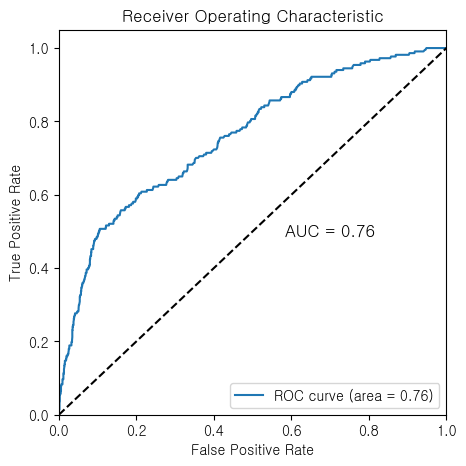

In [78]:
# roc curve, auc
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))

fpr, tpr, thresholds = roc_curve(np.array(mer_data3['ODX_binary']), np.array(mer_data3['Probability']))
roc_auc = auc(fpr, tpr)

plt.text(0.7, 0.5, 'AUC = %0.2f' % roc_auc, ha='center', va='center', fontsize=12, fontweight='bold')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [67]:
mer_data3['pred'] = mer_data3['Probability'].apply(lambda x: 1 if x > 0.5 else 0)

In [68]:
mer_data3['pred'].value_counts()

0    1474
1      43
Name: pred, dtype: int64

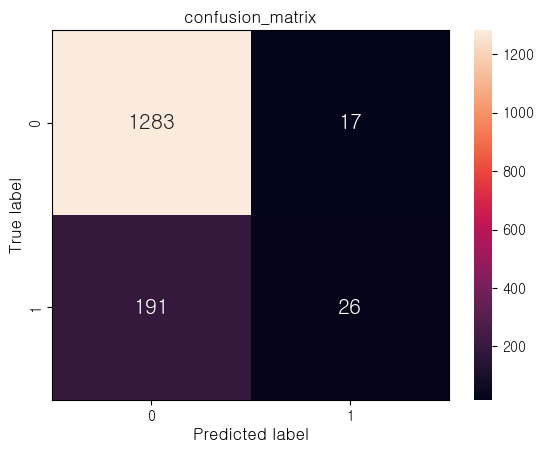

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(mer_data3['ODX_binary'], mer_data3['pred'])

heatmap = sns.heatmap(cm, annot=True, fmt="d")

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    
for t in heatmap.texts:
    t.set_fontsize(15)
    
plt.title('confusion_matrix', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()


In [72]:
TP = len(mer_data3[(mer_data3['ODX_binary']==1)&(mer_data3['pred']==1)])
TN = len(mer_data3[(mer_data3['ODX_binary']==0)&(mer_data3['pred']==0)])
FN = len(mer_data3[(mer_data3['ODX_binary']==1)&(mer_data3['pred']==0)])
FP = len(mer_data3[(mer_data3['ODX_binary']==0)&(mer_data3['pred']==1)])

print(f'tp: {TP}, tn: {TN}, fn: {FN}, fp: {FP}')

performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)

tp: 26, tn: 1283, fn: 191, fp: 17


,Sensitivity,Specificity,Accuracy,PPV,NPV,F_1 score
0,11.981567,98.692308,86.288728,60.465116,87.042062,20.0


In [73]:
print(classification_report(mer_data3['ODX_binary'], mer_data3['pred']))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      1300
         1.0       0.60      0.12      0.20       217

    accuracy                           0.86      1517
   macro avg       0.74      0.55      0.56      1517
weighted avg       0.83      0.86      0.82      1517

